# VAE Chinese glyphs explorer

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1) # Output size: [32, 32, 32]
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # Output size: [64, 16, 16]
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Output size: [128, 8, 8]
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Output size: [256, 4, 4]
        
        # Latent vectors mu and logvar
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc_mu = nn.Linear(512, 256)
        self.fc_logvar = nn.Linear(512, 256)

        # Decoder
        self.fc2 = nn.Linear(256, 256*4*4)
        self.conv5 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv7 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.conv8 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = h.view(-1, 256*4*4)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        h = h.view(-1, 256, 4, 4)
        h = F.relu(self.conv5(h))
        h = F.relu(self.conv6(h))
        h = F.relu(self.conv7(h))
        return torch.sigmoid(self.conv8(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [2]:
# Initialize model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialize dataloader
class ChineseCharacterDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = os.listdir(folder_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(),  # Convert to monochrome
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.file_names[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        return image

dataset = ChineseCharacterDataset('data')
# data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Train-test split
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% of the dataset for training
test_size = total_size - train_size  # Remaining 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

Run a training loop

Check the reconstructions

In [3]:
def show_reconstructions(model, data_loader, num_images=6):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Get a batch of images
        for batch in data_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break  # We only need one batch

    batch = batch.cpu()
    recon = recon.cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Display original images
        axs[0, i].imshow(batch[i].reshape(64, 64), cmap='gray')
        axs[0, i].set_title(f"Original {i+1}")
        axs[0, i].axis('off')

        # Display reconstructed images
        axs[1, i].imshow(recon[i].reshape(64, 64), cmap='gray')
        axs[1, i].set_title(f"Reconstructed {i+1}")
        axs[1, i].axis('off')

    plt.show()

# Assuming you already have your model and data_loader
# show_reconstructions(model, test_loader, num_images=6)

Load a saved model 

Loading model on: cuda


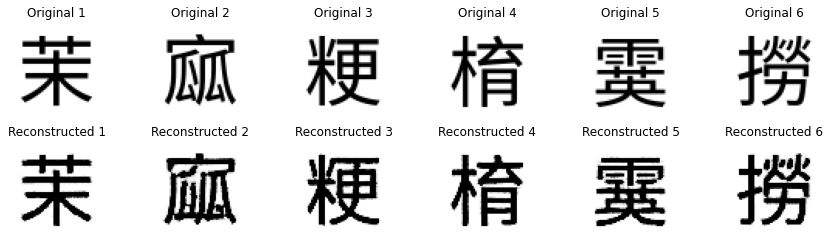

In [4]:
def load_model(model_path, model_architecture):
    """
    Loads a model from the specified path onto the GPU.

    Args:
    model_path (str): Path to the .pth file of the saved model.
    model_architecture (nn.Module): The architecture of the model (should match the saved model).

    Returns:
    The loaded model.
    """
    if not os.path.isfile(model_path):
        print(f"Model file not found: {model_path}")
        return None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on: {device}")

    model = model_architecture().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

# Example usage
model_path = './saved_models/model_epoch_200.pth'
loaded_model = load_model(model_path, VAE)

# Do something with loaded_model
show_reconstructions(loaded_model, test_loader, num_images=6)

In [5]:
# Example usage
model_path = './saved_models/model_epoch_200.pth'
model = load_model(model_path, VAE)
model.eval()  # Set the model to evaluation mode
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Move model to appropriate device


Loading model on: cuda


Load full dataset

In [6]:
dataset = ChineseCharacterDataset('data')
data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

Collect latent vectors

In [7]:
# Load latent vectors
latent_vectors = np.load('latent_vectors.npy')
latent_2d = np.load('latent_2d.npy')

## Generate interpolated latent vectors

In [31]:
def interpolate_latent_space(vae, start_vector, end_vector, steps):
    interpolated_vectors = []
    for alpha in np.linspace(0, 1, steps):
        # Linear interpolation
        interp_vector = start_vector * (1 - alpha) + end_vector * alpha
        interpolated_vectors.append(interp_vector)
    return interpolated_vectors

def decode_vectors_to_images(vae, latent_vectors):
    images = []
    with torch.no_grad():
        for i, vector in enumerate(latent_vectors):
            image = vae.decode(vector).cpu()
            # Ensure the output is (C, H, W), then convert to (H, W, C)
            image = image.squeeze(0).permute(1, 2, 0).numpy()
            # Ensure pixel values are in the range [0, 255]
            # image = ((image + 1) * 127.5).astype(np.uint8)
            image = (image * 255).astype(np.uint8)
            images.append(image)

            # Check image shape and type
            if i < 5:  # Check for the first few images
                print(f"Image {i} shape: {image.shape}, type: {image.dtype}")
                plt.imshow(image, cmap='gray')
                plt.show()
    return images


def create_video(images, video_path, fps=60, scale_factor=8):
    if len(images) == 0:
        print("No images provided to create video.")
        return

    # Original dimensions
    original_height, original_width = images[0].shape[:2]

    # Scaled dimensions
    width, height = int(original_width * scale_factor), int(original_height * scale_factor)

    # H.264 codec shares best on whatsapp
    # video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))
    # video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height)
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'X264'), fps, (width, height))

    for image in images:
        # Convert from RGB to BGR
        bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Resize the image
        resized_image = cv2.resize(bgr_image, (width, height), interpolation=cv2.INTER_LINEAR)
        video.write(resized_image)
        cv2.imshow("Frame", resized_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

# Example usage:
# create_video(decoded_images, 'upscaled_video.avi', fps=30, scale_factor=2)


Image 0 shape: (64, 64, 1), type: uint8


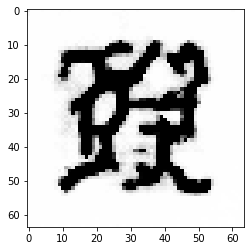

Image 1 shape: (64, 64, 1), type: uint8


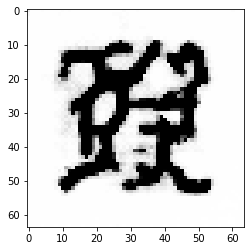

Image 2 shape: (64, 64, 1), type: uint8


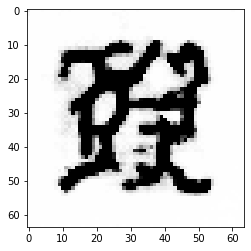

Image 3 shape: (64, 64, 1), type: uint8


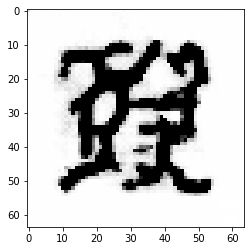

Image 4 shape: (64, 64, 1), type: uint8


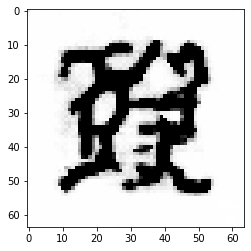

In [9]:

# Generate random start and end vectors or use vectors from your dataset
start_vector = torch.randn(1, 256).to(device)  # Replace latent_size with your model's latent size
end_vector = torch.randn(1, 256).to(device)

# Interpolate in the latent space
interpolated_vectors = interpolate_latent_space(model, start_vector, end_vector, steps=120)

# Decode the vectors into images
decoded_images = decode_vectors_to_images(model, interpolated_vectors)

# # Create video from images
video_path = 'latent_space_interpolation.avi'
create_video(decoded_images, video_path, fps=60)


In [11]:
import torch
from torchvision import transforms
from PIL import Image
import os

def get_latent_vectors_for_unicode(vae, unicode_codes, data_folder='./data', image_size=64):
    """
    Retrieves the latent vectors for given Unicode codes by encoding corresponding images.

    Args:
    vae (nn.Module): Trained VAE model.
    unicode_codes (list): List of Unicode codes.
    data_folder (str): Path to the folder containing the images.
    image_size (int): Size to which images are resized.

    Returns:
    List of torch.Tensor: The latent vectors corresponding to the Unicode codes.
    """
    latent_vectors = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)  # Move the VAE model to the GPU if available

    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to monochrome
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    for code in unicode_codes:
        image_path = os.path.join(data_folder, f"{code}.png")
        if not os.path.exists(image_path):
            print(f"Image for Unicode {code} not found.")
            continue

        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)  # Apply transformations and move to device

        with torch.no_grad():
            vae.eval()
            mu, _ = vae.encode(image)  # Assuming VAE's encode method returns mu and logvar
            latent_vectors.append(mu.squeeze(0).cpu())  # Remove batch dimension and move to CPU

    return latent_vectors

# Example usage
# vae = ...  # Your trained VAE model
unicode_codes = ['4e00', '4e01']  # Example Unicode codes
latent_vectors = get_latent_vectors_for_unicode(loaded_model, unicode_codes)


In [19]:
def string_to_unicode_codes(input_string):
    """
    Converts each character in a string to its Unicode code.

    Args:
    input_string (str): The input string.

    Returns:
    List[str]: A list of Unicode codes corresponding to each character in the input string.
    """
    unicode_codes = [format(ord(char), 'x') for char in input_string]
    return unicode_codes

# Example usage
input_string = "你好"
unicode_codes = string_to_unicode_codes(input_string)
print(unicode_codes)

['4f60', '597d']


Image 0 shape: (64, 64, 1), type: uint8


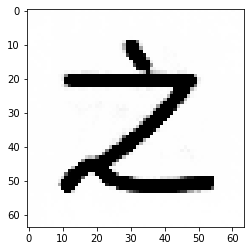

Image 1 shape: (64, 64, 1), type: uint8


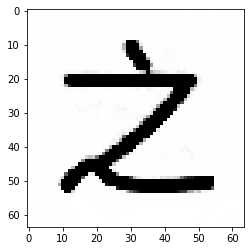

Image 2 shape: (64, 64, 1), type: uint8


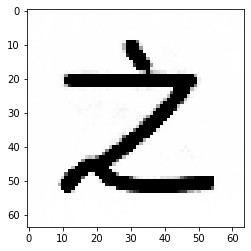

Image 3 shape: (64, 64, 1), type: uint8


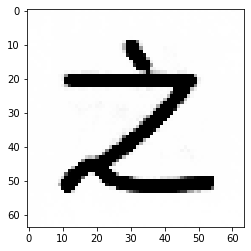

Image 4 shape: (64, 64, 1), type: uint8


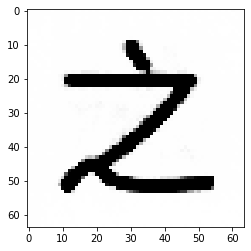

Image 0 shape: (64, 64, 1), type: uint8


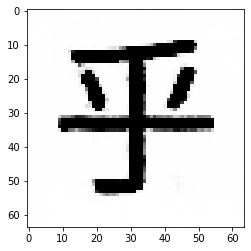

Image 1 shape: (64, 64, 1), type: uint8


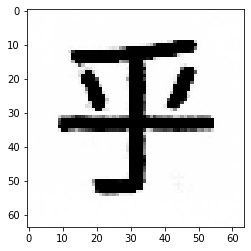

Image 2 shape: (64, 64, 1), type: uint8


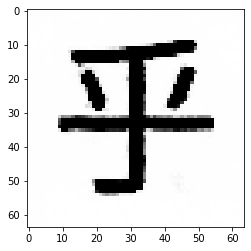

Image 3 shape: (64, 64, 1), type: uint8


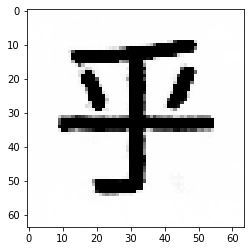

Image 4 shape: (64, 64, 1), type: uint8


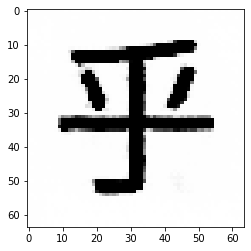

Image 0 shape: (64, 64, 1), type: uint8


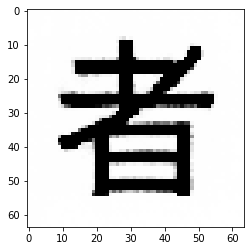

Image 1 shape: (64, 64, 1), type: uint8


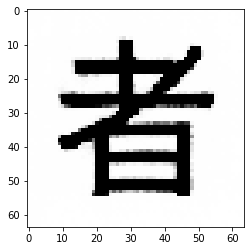

Image 2 shape: (64, 64, 1), type: uint8


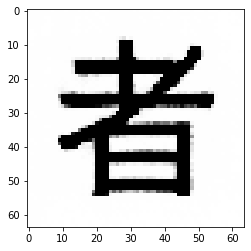

Image 3 shape: (64, 64, 1), type: uint8


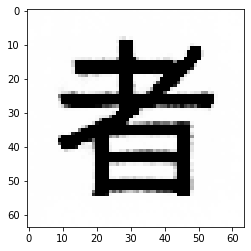

Image 4 shape: (64, 64, 1), type: uint8


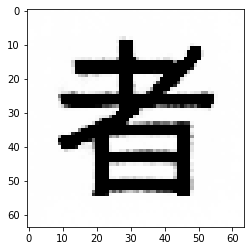

In [32]:
def create_interpolation_video_from_unicode(vae, unicode_codes, data_folder, video_path, steps_per_interpolation=180, fps=60):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)  # Ensure the VAE model is on the correct device

    # Get latent vectors for the given Unicode codes, also ensure they are on the same device
    latent_vectors = get_latent_vectors_for_unicode(vae, unicode_codes, data_folder)
    latent_vectors = [vec.to(device) for vec in latent_vectors]  # Move all latent vectors to the same device

    all_interpolated_images = []

    for i in range(len(latent_vectors) - 1):
        start_vector = latent_vectors[i].unsqueeze(0)
        end_vector = latent_vectors[i+1].unsqueeze(0)

        interpolated_vectors = interpolate_latent_space(vae, start_vector, end_vector, steps_per_interpolation)
        decoded_images = decode_vectors_to_images(vae, interpolated_vectors)
        all_interpolated_images.extend(decoded_images)

    # Create video from all interpolated images
    create_video(all_interpolated_images, video_path, fps)

# Example usage
input_string = "之乎者也"
unicode_codes = string_to_unicode_codes(input_string)
create_interpolation_video_from_unicode(loaded_model, unicode_codes, './data', 'unicode_interpolation2.mp4')
